## Movie Recommendation System for Turner Classic Movies

# Objective
A Recommendation system for older movies for the movie network Turner Classic Movies

# Business Understanding
Amidst large scale changes in viewing habits and content consumption via Cable and Streaming platforms, the importance of engagement with Warner Bros. older film library and older films in general is at an all time high for the profitable cable pay-network of Turner Classic Movies.

A Recommendation system for a younger generation to rate any older movies that they have seen and be given high quality recommendations for other older movies they may not know about will drive network engagement and profit.

# Data Understanding
- Data was provided from grouplens.org MovieLens 25 million review database released 12/2019.
- The database contains 62,000 movies rated by 162,000 users.
- The Data was filtered to movies released up until 1969 as the network focuses on 'classic' movies from the 30s through 60s.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import surprise
from surprise.prediction_algorithms import *
from surprise import accuracy, Dataset, Reader, BaselineOnly

from surprise.model_selection import cross_validate, train_test_split
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline, NMF
from surprise.model_selection import GridSearchCV

In [2]:
movies_df = pd.read_csv('data/ml-25m/ml-25m/movies.csv')
ratings_df = pd.read_csv('data/ml-25m/ml-25m/ratings.csv')

In [4]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [5]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
movies_df['year'] = movies_df['title'].str.extract(r'\((\d{4})\)')

In [7]:
movies_df

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
...,...,...,...,...
62418,209157,We (2018),Drama,2018
62419,209159,Window of the Soul (2001),Documentary,2001
62420,209163,Bad Poems (2018),Comedy|Drama,2018
62421,209169,A Girl Thing (2001),(no genres listed),2001


In [8]:
movies_df['year'].isna().sum()

410

In [9]:
movies_df = movies_df.dropna(subset=['year'])

In [10]:
movies_df['year'].isna().sum()

0

In [11]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62013 entries, 0 to 62422
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62013 non-null  int64 
 1   title    62013 non-null  object
 2   genres   62013 non-null  object
 3   year     62013 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.4+ MB


In [12]:
movies_df_old = movies_df.copy()

In [13]:
movies_df_old['year'] = movies_df_old['year'].astype(int)

In [14]:
movies_df_clean = movies_df_old[movies_df_old['year'] <= 1969]

In [15]:
movies_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12049 entries, 152 to 62422
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  12049 non-null  int64 
 1   title    12049 non-null  object
 2   genres   12049 non-null  object
 3   year     12049 non-null  int32 
dtypes: int32(1), int64(1), object(2)
memory usage: 423.6+ KB


In [16]:
movies_df_final = movies_df_clean.drop('year', axis=1)

In [17]:
movies_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12049 entries, 152 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  12049 non-null  int64 
 1   title    12049 non-null  object
 2   genres   12049 non-null  object
dtypes: int64(1), object(2)
memory usage: 376.5+ KB


In [18]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [19]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [20]:
ratings_df_clean = ratings_df.drop(columns='timestamp')

In [21]:
ratings_df_clean.head()

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


In [22]:
ratings_df_final = ratings_df_clean[ratings_df_clean['movieId'].isin(movies_df_final['movieId'])]

In [23]:
ratings_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1770686 entries, 4 to 25000019
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 54.0 MB


# EDA

In [33]:
movies_df_final.reset_index(inplace=True, drop=True)

In [34]:
movies_df_final

,movieId,title,genres
0,154,Beauty of the Day (Belle de jour) (1967),Drama
1,199,"Umbrellas of Cherbourg, The (Parapluies de Che...",Drama|Musical|Romance
2,390,Faster Pussycat! Kill! Kill! (1965),Action|Crime|Drama
3,594,Snow White and the Seven Dwarfs (1937),Animation|Children|Drama|Fantasy|Musical
4,596,Pinocchio (1940),Animation|Children|Fantasy|Musical
...,...,...,...
12044,209089,An Impossible Balancing Feat (1902),(no genres listed)
12045,209137,The Reward's Yours... The Man's Mine (1969),Western
12046,209139,Rimsky-Korsakov (1953),Drama
12047,209147,The Carpet of Horror (1962),Crime|Horror


In [35]:
ratings_df_final.reset_index(inplace=True, drop=True)

In [36]:
ratings_df_final

,userId,movieId,rating
0,1,899,3.5
1,1,1237,5.0
2,1,1250,4.0
3,1,1260,3.5
4,1,2351,4.5
...,...,...,...
1770681,162541,969,4.0
1770682,162541,1029,3.5
1770683,162541,1201,3.0
1770684,162541,2080,4.0


In [37]:
movies_and_ratings_df = pd.merge(movies_df_final, ratings_df_final, on='movieId', how='right')

In [38]:
movies_and_ratings_df

,movieId,title,genres,userId,rating
0,899,Singin' in the Rain (1952),Comedy|Musical|Romance,1,3.5
1,899,Singin' in the Rain (1952),Comedy|Musical|Romance,31,4.0
2,899,Singin' in the Rain (1952),Comedy|Musical|Romance,58,5.0
3,899,Singin' in the Rain (1952),Comedy|Musical|Romance,59,3.5
4,899,Singin' in the Rain (1952),Comedy|Musical|Romance,72,5.0
...,...,...,...,...,...
1770681,117644,Dr. Socrates (1935),Crime|Drama|Romance,162047,3.5
1770682,123425,The Last Gangster (1937),Crime|Drama|Thriller,162047,3.0
1770683,131211,Copper Canyon (1950),Action|Western,162047,3.0
1770684,151050,The Burning Court (1962),Drama|Horror|Mystery|Thriller,162047,4.0


Graph most popular movies by number of ratings, average rating

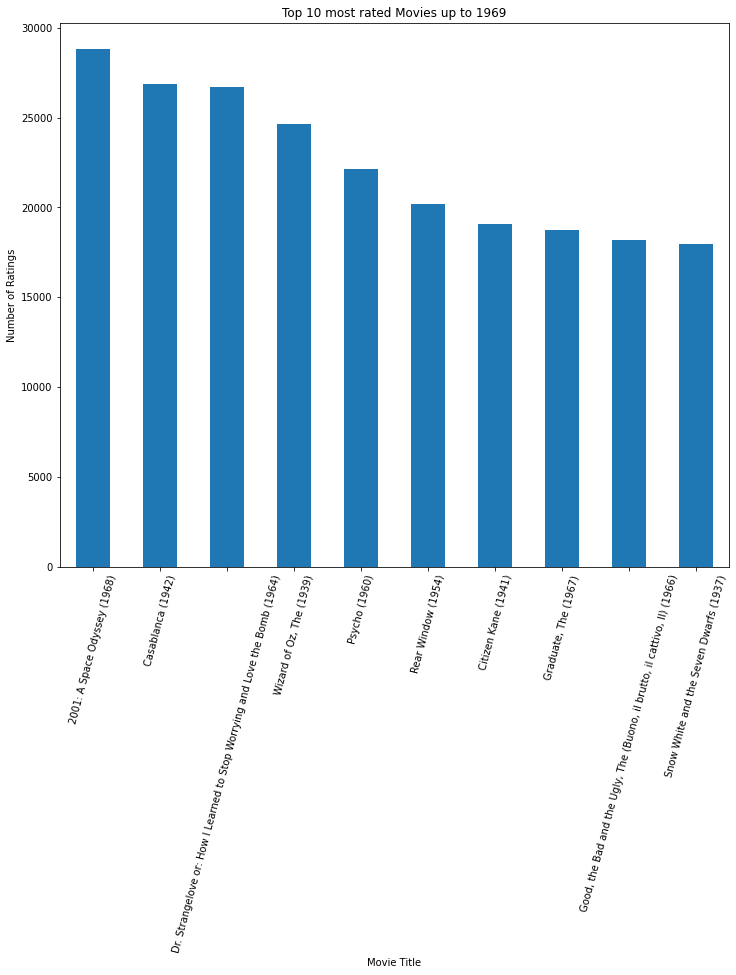

In [109]:
movies_and_ratings_df['title'].value_counts(sort=True).head(10).plot(
    figsize = (12, 10),
    kind = 'bar',
    title = 'Top 10 most rated Movies up to 1969',
    ylabel = 'Number of Ratings',
    xlabel = 'Movie Title',
    );
plt.xticks(rotation=75);

These Movies might have an effect on modeling recommendations because of their number of reviews.

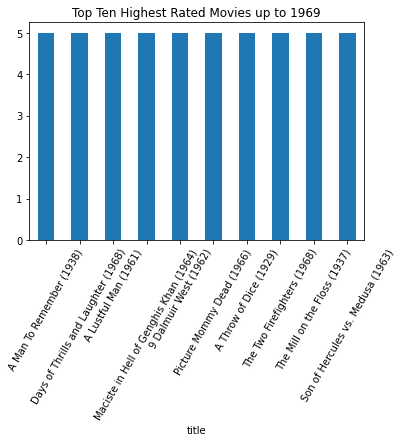

In [113]:
movies_and_ratings_df.groupby('title')['rating'].mean().sort_values(ascending=False).head(10).plot(
    kind='bar',
    title='Top Ten Highest Rated Movies up to 1969',);
plt.xticks(rotation=60);

These Movies might only have 1 5 star rating not necessarily the best overall movies.

# Modeling

In [41]:
ratings_df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1770686 entries, 0 to 1770685
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 40.5 MB


Converting datatypes to less memory intensive units

In [42]:
ratings_df_modeling = ratings_df_final.copy()

In [43]:
ratings_df_modeling['rating'] = ratings_df_modeling['rating'].astype(np.float32)

In [44]:
ratings_df_modeling['userId'] = ratings_df_modeling['userId'].astype(np.int32)

In [45]:
ratings_df_modeling['movieId'] = ratings_df_modeling['movieId'].astype(np.int32)

In [46]:
ratings_df_modeling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1770686 entries, 0 to 1770685
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int32  
 1   movieId  int32  
 2   rating   float32
dtypes: float32(1), int32(2)
memory usage: 20.3 MB


Taking a random sample from dataset to model on because of memory limitations causing crashes.

In [75]:
sampled_df = ratings_df_modeling.sample(frac=0.2, random_state=42)

In [76]:
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354137 entries, 49956 to 1538658
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   354137 non-null  int32  
 1   movieId  354137 non-null  int32  
 2   rating   354137 non-null  float32
dtypes: float32(1), int32(2)
memory usage: 6.8 MB


In [77]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(sampled_df, reader)

In [78]:
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  69958 

Number of items:  6524


More efficient to use item-item similarity because there are less items than users.

In [79]:
trainset, testset = train_test_split(data, test_size=.2, random_state=42)

In [80]:
def train_and_test_pred (algo, trainset, testset): 
    algo.fit(trainset)
   
    train_predictions = algo.test(trainset.build_testset())
    print('biased accuracy on train set: ')
    print(accuracy.rmse(train_predictions))
    print(accuracy.mae(train_predictions))
    test_predictions = algo.test(testset)
    print('unbiased accuracy on test set: ')
    print(accuracy.rmse(test_predictions))
    print(accuracy.mae(test_predictions))

## Baseline KNN Basic Model with pearson correlation and item-item similarity.

In [81]:
baseline_knn_model = KNNBasic(sim_options={'name':'pearson', 'user_based':False})
train_and_test_pred(baseline_knn_model, trainset, testset)

Computing the pearson similarity matrix...
Done computing similarity matrix.
biased accuracy on train set: 
RMSE: 0.4776
0.4776371077572209
MAE:  0.3356
0.3356294394105264
unbiased accuracy on test set: 
RMSE: 0.9244
0.9244280341868037
MAE:  0.6884
0.6884367933339277


In [82]:
cv_knn_basic = cross_validate(baseline_knn_model, data, n_jobs=-1)

In [83]:
print(np.mean(cv_knn_basic['test_rmse']))
print(np.mean(cv_knn_basic['test_mae']))

0.9223537387054842
0.6858030683026867


## Baseline KNNBasic model with no hyperparameter tuning has cross-validation RMSE of .922 and MAE of .686

In [84]:
#Gridsearch KNN Basic Model to see best params for KNN Basic
params = {'k': [30, 40, 50],
         'sim_options': {'name':['cosine', 'pearson', 'pearson_baseline'],
                        'user_based': [False]}
         }
KNNBasic_gridsearch = GridSearchCV(KNNBasic, param_grid = params, cv = 5)
KNNBasic_gridsearch.fit(data)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
E

In [85]:
print(KNNBasic_gridsearch.best_params)
print(KNNBasic_gridsearch.best_score)

{'rmse': {'k': 50, 'sim_options': {'name': 'cosine', 'user_based': False}}, 'mae': {'k': 50, 'sim_options': {'name': 'cosine', 'user_based': False}}}
{'rmse': 0.9030194300789629, 'mae': 0.6744452659461593}


In [86]:
KNNBasic_best = KNNBasic_gridsearch.best_estimator['mae']
train_and_test_pred(KNNBasic_best, trainset, testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.
biased accuracy on train set: 
RMSE: 0.6860
0.6860082926664759
MAE:  0.4935
0.49348456873384555
unbiased accuracy on test set: 
RMSE: 0.9035
0.9035244326452927
MAE:  0.6755
0.6755292353860275


In [87]:
cv_best_knnbasic = cross_validate(KNNBasic_best, data)
print(np.mean(cv_best_knnbasic['test_rmse']))
print(np.mean(cv_best_knnbasic['test_mae']))

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
0.903318482771228
0.6744367099733385


# KNN Basic tuned model has RMSE of .903 and MAE of .674, a small improvement from KNN Basic baseline model RMSE of .922 and MAE of .686.

# KNNBaseline Model

In [88]:
knn_baseline = KNNBaseline(sim_options={'name': 'pearson', 'user_based':False})
cv_knn_baseline = cross_validate(knn_baseline, data)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [89]:
train_and_test_pred(knn_baseline, trainset, testset)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
biased accuracy on train set: 
RMSE: 0.4408
0.44079145638821143
MAE:  0.3099
0.30993861978189313
unbiased accuracy on test set: 
RMSE: 0.8687
0.8686656724204926
MAE:  0.6473
0.6473432964384331


# KNNBaseline model has RMSE of .869 and MAE of .647, a small improvement over KNNBasic.

# SVD Modeling

In [93]:
svd=SVD()
cv_svd = cross_validate(svd, data)

In [94]:
print(np.mean(cv_svd['test_rmse']))
print(np.mean(cv_svd['test_mae']))

0.8501779253926015
0.652425383535131


Baseline SVD RMSE is .85 and MAE is .652

In [91]:
## Gridsearch with SVD
params = {'n_factors': [50, 100, 150],
          'reg_all': [0.02, 0.05, 0.07],
          'n_epochs': [20, 40],
          'lr_all': [0.005, 0.007]}

SVD_gridsearch = GridSearchCV(SVD, param_grid=params, n_jobs=-1)
SVD_gridsearch.fit(data)

In [92]:
print(SVD_gridsearch.best_score)
print(SVD_gridsearch.best_params)

{'rmse': 0.8262027208665013, 'mae': 0.6320025781477152}
{'rmse': {'n_factors': 50, 'reg_all': 0.07, 'n_epochs': 40, 'lr_all': 0.007}, 'mae': {'n_factors': 50, 'reg_all': 0.07, 'n_epochs': 40, 'lr_all': 0.007}}


In [95]:
SVD_best = SVD_gridsearch.best_estimator['mae']

In [96]:
train_and_test_pred(SVD_best, trainset, testset)

biased accuracy on train set: 
RMSE: 0.6068
0.6068419849737842
MAE:  0.4701
0.4700870374913426
unbiased accuracy on test set: 
RMSE: 0.8259
0.8259084615577506
MAE:  0.6319
0.6319392743904649


In [98]:
cv_best_svd = cross_validate(SVD_best, data)
print("mean test rmse", np.mean(cv_best_svd['test_rmse']))
print("mean test mae", np.mean(cv_best_svd['test_mae']))

mean test rmse 0.8268223022536496
mean test mae 0.6323691991135918


# Tuned SVD model RMSE of .827 and MAE of .632 is best performing model so far.

# NMF Model

In [99]:
nmf = NMF()

cv_nmf = cross_validate(nmf, data)
print(np.mean(cv_nmf['test_rmse']))
print(np.mean(cv_nmf['test_mae']))

0.9179157030692753
0.7001355204170869


Baseline NMF RMSE .918  and MAE .7

In [101]:
params = {'n_factors': [10, 15, 20],
          'n_epochs': [25, 50, 75],
          'reg_pu': [.06, .08],
          'reg_qi': [.06, .08],
          'biased': [True, False]}

nmf_gridsearch = GridSearchCV(NMF, param_grid = params, n_jobs=-1)
nmf_gridsearch.fit(data)

In [102]:
print(nmf_gridsearch.best_params)
print(nmf_gridsearch.best_score)

{'rmse': {'n_factors': 10, 'n_epochs': 75, 'reg_pu': 0.08, 'reg_qi': 0.08, 'biased': True}, 'mae': {'n_factors': 10, 'n_epochs': 75, 'reg_pu': 0.08, 'reg_qi': 0.08, 'biased': True}}
{'rmse': 0.8564938370905569, 'mae': 0.6609018992604911}


In [103]:
nmf_best = nmf_gridsearch.best_estimator['mae']
train_and_test_pred(nmf_best, trainset, testset)

biased accuracy on train set: 
RMSE: 0.5802
0.5802438624058601
MAE:  0.4309
0.43091557081838694
unbiased accuracy on test set: 
RMSE: 0.8563
0.8563335241233426
MAE:  0.6617
0.6616785593796172


In [104]:
cv_best_nmf = cross_validate(nmf_best, data)
print("mean test rmse", np.mean(cv_best_nmf['test_rmse']))
print("mean test mae", np.mean(cv_best_nmf['test_mae']))

mean test rmse 0.8580969704453805
mean test mae 0.6628520751536366


Tuned NMF Model has RMSE .858 of and MAE of .663 making it 2nd best model behind SVD

# Best Model is SVD and will be used in recommendation System below

In [105]:
best_model = SVD(n_factors=50, n_epochs=40, reg_all=.07, lr_all=.007)
best_model.fit(trainset)

In [106]:
best_model.test(testset)
accuracy.rmse(best_model.test(testset))

RMSE: 0.8260


0.8260000762967017

In [108]:
accuracy.mae(best_model.test(testset))

MAE:  0.6316


0.6316289598268595

Simple prediction

In [107]:
best_model.predict(2, 4)

Prediction(uid=2, iid=4, r_ui=None, est=3.4252475569642225, details={'was_impossible': False})

## Function for a user to rate movies and receive recommendations using model

In [114]:
def movie_rater(movies_df_final, num, genre=None):
    userID = 110000
    rating_list = []
    while num > 0:
        if genre:
            movie = movies_df_final[movies_df_final['genres'].str.contains(genre)].sample(1)
        else:
            movie = movies_df_final.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            num -= 1
    return rating_list

In [115]:
user_rating = movie_rater(movies_df_final, 5, 'Thriller')

      movieId                         title                   genres
5996   124109  The Shadow of the Cat (1961)  Horror|Mystery|Thriller
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5
      movieId                   title                 genres
6043   124257  Run for the Sun (1956)  Action|Drama|Thriller
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5
      movieId                           title            genres
5597   122141  So Sweet... So Perverse (1969)  Mystery|Thriller
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5
      movieId                                           title           genres
8816   156671  Let's Kill Uncle, Before Uncle Kills Us (1966)  Horror|Thriller
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5
       movieId                           title                  genres
10388   177953  Radar Men from the Moon (1952)  Action|Sci-Fi|Thril

In [116]:
user_rating

[{'userId': 110000, 'movieId': 124109, 'rating': '5'},
 {'userId': 110000, 'movieId': 124257, 'rating': '5'},
 {'userId': 110000, 'movieId': 122141, 'rating': '5'},
 {'userId': 110000, 'movieId': 156671, 'rating': '5'},
 {'userId': 110000, 'movieId': 177953, 'rating': '5'}]

In [117]:
user_ratings = pd.DataFrame(user_rating)
new_ratings_df = pd.concat([ratings_df_final, user_ratings], axis=0)
new_data = Dataset.load_from_df(new_ratings_df, reader)

In [118]:
new_ratings_df

,userId,movieId,rating
0,1,899,3.5
1,1,1237,5
2,1,1250,4
3,1,1260,3.5
4,1,2351,4.5
...,...,...,...
0,110000,124109,5
1,110000,124257,5
2,110000,122141,5
3,110000,156671,5


In [119]:
svd_ = SVD(n_factors=50, n_epochs=40, reg_all=.07, lr_all=.007)
svd_.fit(new_data.build_full_trainset())

In [120]:
list_of_movies = []
for m_id in ratings_df_final['movieId'].unique():
    list_of_movies.append( (m_id,svd_.predict(110000,m_id)[3]))

In [121]:
ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)

In [122]:
def recommended_movies(user_ratings, movies_df_final, n):
    for idx, rec in enumerate(user_ratings):
        title = movies_df_final.loc[movies_df_final['movieId'] == int(rec[0])]['title']
        print('Recommendation # ', idx+1, ': ', title, '\n')
        n-= 1
        if n == 0:
            break
            
recommended_movies(ranked_movies, movies_df_final, 5)

Recommendation #  1 :  219    Seven Samurai (Shichinin no samurai) (1954)
Name: title, dtype: object 

Recommendation #  2 :  148    12 Angry Men (1957)
Name: title, dtype: object 

Recommendation #  3 :  14    Dr. Strangelove or: How I Learned to Stop Worr...
Name: title, dtype: object 

Recommendation #  4 :  31    Rear Window (1954)
Name: title, dtype: object 

Recommendation #  5 :  150    To Kill a Mockingbird (1962)
Name: title, dtype: object 



On test recommendations 2 of the most reviewed movies do show up possibly biasing results to most popular movies but the recommendation system does work.